In [1]:
#Import libraries
import numpy as np
import pandas as pd

In [2]:
#Import data
df = pd.read_csv('UdemyWikipediaVisitsDatabase.csv')
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


In [3]:
#Descriptive statistics
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


<Axes: >

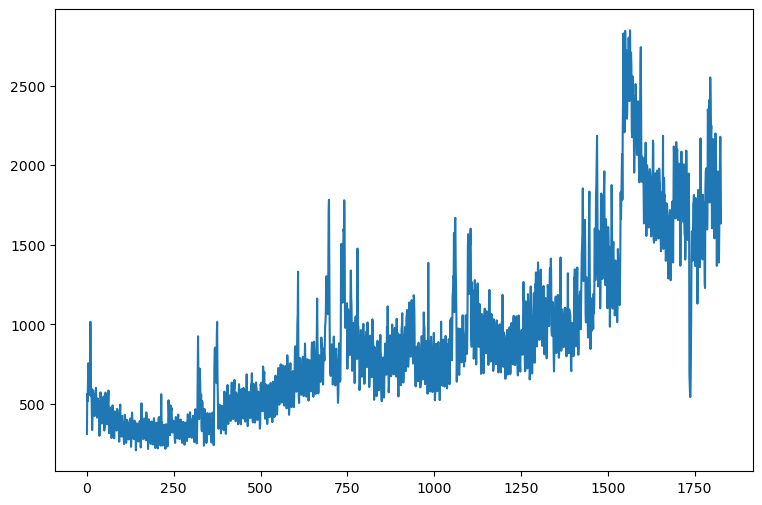

In [4]:
#Data distribution
df['Udemy'].plot(figsize=(9, 6))

In [5]:
#Change date format: %m/%d/%Y -> %Y-%m-%d
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [6]:
#Change variable names: Date -> ds, Udemy -> y
df = df.rename(columns={'Date':'ds', 'Udemy':'y'})
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [7]:
#Holidays
# Easter
easter_dates = df[df['Easter']==1]['ds']
easter_dates

86     2016-03-27
471    2017-04-16
821    2018-04-01
1206   2019-04-21
1563   2020-04-12
Name: ds, dtype: datetime64[ns]

In [8]:
# Create Easter dataframe
easter = pd.DataFrame({'holiday':'easter', 'ds':easter_dates, 'lower_window':-5, 'upper_window':2})
easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


In [9]:
# Black Friday
black_friday_dates = df[df['Black Friday']==1]['ds']
black_friday_dates

329    2016-11-25
693    2017-11-24
1057   2018-11-23
1428   2019-11-29
1792   2020-11-27
Name: ds, dtype: datetime64[ns]

In [10]:
# Create Black Friday dataframe
black_friday = pd.DataFrame({'holiday':'black_friday', 'ds':black_friday_dates, 'lower_window':-7, 'upper_window':5})
black_friday

,holiday,ds,lower_window,upper_window
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [11]:
# Combine the holidays
holidays = pd.concat([easter, black_friday])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [12]:
#Drop Easter and Black Friday from the main dataframe
df = df.drop(columns=['Easter', 'Black Friday'])
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


In [13]:
#Training and test sets
test_days = 31
test = df.iloc[-31: , :]
training = df.iloc[:-30, :]
print(training.tail(1))
print(test.head(1))

             ds     y  Christmas
1796 2020-12-01  2393          0
             ds     y  Christmas
1796 2020-12-01  2393          0


In [15]:
#Prophet model
from prophet import Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays, seasonality_mode='multiplicative')
model.add_regressor('Christmas')
model.fit(training)

In [16]:
#Regressor coefficients
from prophet.utilities import regressor_coefficients
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.293283,-0.293283,-0.293283


In [17]:
#Create future dataframe
future = model.make_future_dataframe(periods=test_days, freq='D')
future = pd.concat([future, df.iloc[:,2:]], axis=1)
future = pd.DataFrame.dropna(future)
future

,ds,Christmas
0,2016-01-01,0.0
1,2016-01-02,0.0
2,2016-01-03,0.0
3,2016-01-04,0.0
4,2016-01-05,0.0
...,...,...
1822,2020-12-27,0.0
1823,2020-12-28,0.0
1824,2020-12-29,0.0
1825,2020-12-30,0.0


In [18]:
#Predictions
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,black_friday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,440.413818,275.897222,651.869117,440.413818,440.413818,0.0,0.0,0.0,0.0,...,-0.023096,-0.023096,-0.023096,0.072739,0.072739,0.072739,0.0,0.0,0.0,462.277103
1,2016-01-02,439.537633,218.845772,579.791478,439.537633,439.537633,0.0,0.0,0.0,0.0,...,-0.177992,-0.177992,-0.177992,0.098407,0.098407,0.098407,0.0,0.0,0.0,404.557132
2,2016-01-03,438.661448,236.251043,618.686439,438.661448,438.661448,0.0,0.0,0.0,0.0,...,-0.140652,-0.140652,-0.140652,0.123206,0.123206,0.123206,0.0,0.0,0.0,431.008645
3,2016-01-04,437.785263,339.315047,729.235609,437.785263,437.785263,0.0,0.0,0.0,0.0,...,0.077057,0.077057,0.077057,0.146734,0.146734,0.146734,0.0,0.0,0.0,535.757549
4,2016-01-05,436.909079,372.501649,751.627818,436.909079,436.909079,0.0,0.0,0.0,0.0,...,0.098591,0.098591,0.098591,0.168608,0.168608,0.168608,0.0,0.0,0.0,553.650523


In [19]:
#Columns' name
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas', 'Christmas_lower', 'Christmas_upper', 'black_friday',
       'black_friday_lower', 'black_friday_upper', 'easter', 'easter_lower',
       'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'yhat'],
      dtype='object')

In [20]:
#Predictions' result
forecast[(forecast['black_friday'].abs()>0)&(forecast['ds']>'2020-01-01')][['ds', 'black_friday']]

,ds,black_friday
1785,2020-11-20,0.084939
1786,2020-11-21,0.101901
1787,2020-11-22,0.143210
1788,2020-11-23,0.177057
1789,2020-11-24,0.160879
1790,2020-11-25,0.138294
1791,2020-11-26,0.181172
1792,2020-11-27,0.384042
1793,2020-11-28,0.193898
1794,2020-11-29,0.210399


In [21]:
#Predictions' result
prediction = forecast['yhat'][-test_days:]
prediction

1796    2674.259427
1797    2777.106741
1798    2065.433347
1799    1849.991361
1800    1508.766111
1801    1573.622123
1802    2020.978122
1803    2050.910146
1804    2021.670480
1805    1966.236403
1806    1745.016887
1807    1400.961524
1808    1469.840371
1809    1928.061473
1810    1970.271202
1811    1957.139396
1812    1921.719540
1813    1723.209949
1814    1404.495552
1815    1504.543405
1816    1999.043052
1817    2076.522420
1818    2099.417479
1819    2100.261628
1820    1301.802701
1821    1650.570013
1822    1784.244643
1823    2312.287915
1824    2417.004094
1825    2462.615435
1826    2481.283070
Name: yhat, dtype: float64

In [22]:
#Model assessment
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(mean_absolute_error(test['y'], prediction))
print(np.sqrt(mean_squared_error(test['y'], prediction)))

208.0354251207701
276.96095185876544
